In [42]:
import numpy as np
import sys
sys.path.append("..")
import dl
import matplotlib.pyplot as plt
import time

In [2]:
trainX_raw = np.load("../data/train_data.npy")
trainy_raw = np.load("../data/train_label.npy")
testX_raw = np.load("../data/test_data.npy")
testy_raw = np.load("../data/test_label.npy")

In [13]:
np.shape(trainX_raw)

(50000, 128)

In [14]:
np.unique(trainy_raw)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [16]:
np.shape(testX_raw)

(10000, 128)

In [17]:
np.unique(testy_raw)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [22]:
np.bincount(trainy_raw.flatten())

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

In [23]:
class Mlp3(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=dl.nn.kai_ming_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

In [28]:
class Mlp2(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

In [31]:
class Mlp4(dl.nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=dl.nn.kai_ming_normal_init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=dl.nn.kai_ming_normal_init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 16, initializer=dl.nn.kai_ming_normal_init)
        self.bn3 = dl.Layers.BatchNormLayer(16)
        self.dp3 = dl.Layers.DropoutLayer(0.25)
        self.fc4 = dl.Layers.DenseLayer(16, 10, initializer=dl.nn.kai_ming_normal_init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.dp3(out)
        out = dl.relu(out)
        out = self.fc4(out)
        return self.out(out)

In [6]:
def train(model, loss_func, scheduler, optimizer):
    model.train()
    train_loss_epoch = 0
    train_accuracy_epoch = 0
    for x, y in trainset:
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_func(y, yhat)
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item
        train_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    train_loss_epoch /= len(trainset)
    train_accuracy_epoch /= len(trainset)
    scheduler.step(train_loss_epoch)
    model.eval()
    test_loss_epoch = 0
    test_accuracy_epoch = 0
    for x, y in testset:
        yhat = model(x)
        loss = loss_func(y, yhat)
        test_loss_epoch += np.mean(loss.item)
        test_accuracy_epoch += dl.metrics.accuracy(y, yhat)
    test_loss_epoch /= len(testset)
    test_accuracy_epoch /= len(testset)
    print(f"Train loss {train_loss_epoch}, Train acc: {train_accuracy_epoch}, "
          f"Test loss: {test_loss_epoch}, Test acc: {test_accuracy_epoch}")
    return train_loss_epoch, train_accuracy_epoch,\
            test_loss_epoch, test_accuracy_epoch

In [32]:
#Layer Test
standardizer = dl.utils.preprocessing.StandardScaler()

trainX = standardizer.fit(trainX_raw)
testX = standardizer.transform(testX_raw)

trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

models = [Mlp2(), Mlp3(), Mlp4()]
LayersEXP = []
time_cost_layerEXP = []
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    time_cost_layerEXP.append(end-begin)
    LayersEXP.append(session.get_evaluation_data())

Epoch 1: Train loss 0.19175344074155024, Train acc: 0.31850961538461536, Test loss: 0.16741101162493388, Test acc: 0.4170673076923077
Epoch 2: Train loss 0.1717310225618415, Train acc: 0.38743990384615384, Test loss: 0.16162193411475947, Test acc: 0.43179086538461536
Epoch 3: Train loss 0.16719363750025987, Train acc: 0.4031650641025641, Test loss: 0.1578659354032287, Test acc: 0.44551282051282054
Epoch 4: Train loss 0.16416547564072892, Train acc: 0.4150440705128205, Test loss: 0.15497599143551644, Test acc: 0.45622996794871795
Epoch 5: Train loss 0.162012819243472, Train acc: 0.4188902243589744, Test loss: 0.1530573535585013, Test acc: 0.4609375
Epoch 6: Train loss 0.16091595873163841, Train acc: 0.42489983974358975, Test loss: 0.15171674170286617, Test acc: 0.46464342948717946
Epoch 7: Train loss 0.15969729225689103, Train acc: 0.428926282051282, Test loss: 0.1507206948918489, Test acc: 0.46434294871794873
Epoch 8: Train loss 0.158639430443517, Train acc: 0.43032852564102564, Test l

2Hiddenlayer 101.91461563110352 EarlyStopped with best score 0.48457532051282054 at epoch 33
3Hiddenlayer 89.39232206344604 EarlyStopped with best score 0.5068108974358975 at epoch 18
4Hiddenlayer 331.5036804676056 EarlyStopped with best score 0.4891826923076923 at epoch 72


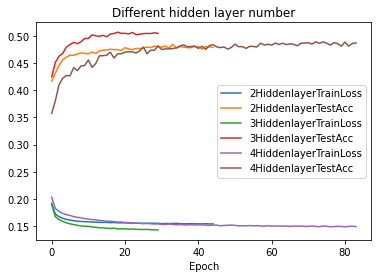

In [39]:
# layer
data = LayersEXP
candidate = ["2Hiddenlayer","3Hiddenlayer", "4Hiddenlayer"]
res = (
    "EarlyStopped with best score 0.48457532051282054 at epoch 33",
    "EarlyStopped with best score 0.5068108974358975 at epoch 18",
    "EarlyStopped with best score 0.4891826923076923 at epoch 72"
)
plt.title("Different hidden layer number")
plt.xlabel("Epoch")
times = time_cost_layerEXP


train_loss = [[i[0] for i in j] for j in data]
test_acc = [[i[3] for i in j] for j in data]

for i in range(len(data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time[i], res[i])

plt.legend()
plt.show()

In [43]:
#bs Test
stabsEXPrdizer = dl.utils.preprocessing.StandardScaler()

trainX = standardizer.fit(trainX_raw)
testX = standardizer.transform(testX_raw)

trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)
#####
models = [Mlp3(), Mlp3(), Mlp3()]
bsize = [64, 128, 256]
bsEXP = []
time_cost_bsEXP = []
res_bs = []
######
for i in range(len(models)):
    trainset = dl.dataset.DataSet(trainX, trainy, batch_size=bsize[i], shuffle=True)
    testset = dl.dataset.DataSet(testX, testy, batch_size=bsize[i], shuffle=True)
    
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost_bsEXP.append(end-begin)
    bsEXP.append(session.get_evaluation_data())
    res_bs.append(session.get_evaluation_data()[session.best_round])
    ####

Epoch 1: Train loss 0.18671366439061207, Train acc: 0.32324343790012805, Test loss: 0.16167674136077037, Test acc: 0.4205729166666667
Epoch 2: Train loss 0.1679074678641776, Train acc: 0.3936859795134443, Test loss: 0.15423533495523672, Test acc: 0.44861778846153844
Epoch 3: Train loss 0.16195855306256424, Train acc: 0.4148927656850192, Test loss: 0.14997172625975758, Test acc: 0.4609375
Epoch 4: Train loss 0.15869744281535267, Train acc: 0.42827704865556976, Test loss: 0.14761583741678025, Test acc: 0.47245592948717946
Epoch 5: Train loss 0.1564406325917194, Train acc: 0.43607954545454547, Test loss: 0.14607413156237667, Test acc: 0.47375801282051283
Epoch 6: Train loss 0.15456089307513915, Train acc: 0.4432018245838668, Test loss: 0.14493039171755834, Test acc: 0.48127003205128205
Epoch 7: Train loss 0.15311448137952183, Train acc: 0.4473231434058899, Test loss: 0.14318462189017966, Test acc: 0.4852764423076923
Epoch 8: Train loss 0.15166611980460645, Train acc: 0.45408530729833546, 

64 199.26291918754578 (0.14128329968365536, 0.4941781370038412, 0.13486266610181147, 0.5168269230769231)
128 74.81912565231323 (0.14380729895138672, 0.4839142628205128, 0.13642734879370158, 0.510917467948718)
256 52.75926446914673 (0.14495926748988816, 0.4775641025641026, 0.13772911234045684, 0.5073116987179487)


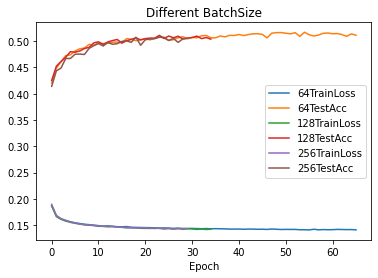

In [45]:
# bs
data = bsEXP
candidate = ["64","128", "256"]
res = res_bs
plt.title("Different BatchSize")
plt.xlabel("Epoch")
times = time_cost_bsEXP


train_loss = [[i[0] for i in j] for j in data]
test_acc = [[i[3] for i in j] for j in data]

for i in range(len(data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], times[i], res[i])

plt.legend()
plt.show()

In [56]:
# Preprocessing Test
standardizer = dl.utils.preprocessing.StandardScaler()

trainX = standardizer.fit(trainX_raw)
testX = standardizer.transform(testX_raw)

trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

strainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
stestset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

rawtrainset = dl.dataset.DataSet(trainX_raw, trainy, batch_size=128, shuffle=True)
rawtestset = dl.dataset.DataSet(testX_raw, testy, batch_size=128, shuffle=True)
#####
models = [Mlp3(), Mlp3()]
candidate = [(strainset, stestset), (rawtrainset, rawtestset)]
eval_data = []
time_cost = []
best_data = []
best_round = []
######
for i in range(len(models)):
    trainset, testset = candidate[i]
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.SGDOptimizer(models[i].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.18878491732153818, Train acc: 0.31354166666666666, Test loss: 0.1617006199398982, Test acc: 0.42357772435897434
Epoch 2: Train loss 0.16854377714931973, Train acc: 0.3904046474358974, Test loss: 0.15422396856448134, Test acc: 0.445713141025641
Epoch 3: Train loss 0.1623942328852739, Train acc: 0.41227964743589746, Test loss: 0.14995632403617135, Test acc: 0.4600360576923077
Epoch 4: Train loss 0.1594314414023059, Train acc: 0.42215544871794874, Test loss: 0.14683459705407165, Test acc: 0.4740584935897436
Epoch 5: Train loss 0.15663543779196432, Train acc: 0.43303285256410257, Test loss: 0.14447480239423235, Test acc: 0.47966746794871795
Epoch 6: Train loss 0.15438349756474526, Train acc: 0.4437900641025641, Test loss: 0.14327444393699493, Test acc: 0.4859775641025641
Epoch 7: Train loss 0.15327408853956626, Train acc: 0.4465144230769231, Test loss: 0.14270851102982124, Test acc: 0.4829727564102564
Epoch 8: Train loss 0.1516302750363452, Train acc: 0.453125, Test l

standardized 158.72059392929077 (0.14112555041951053, 0.4934094551282051, 0.1357830322218242, 0.5115184294871795) 28
raw 151.3990032672882 (0.14296749720073904, 0.4845152243589744, 0.13549654543886933, 0.5188301282051282) 40


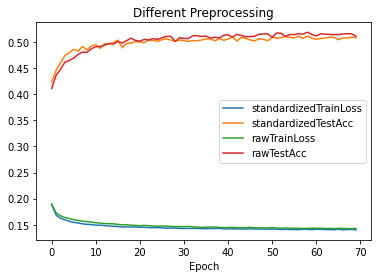

In [57]:
# preprocess
candidate = ["standardized", "raw"]
plt.title("Different Preprocessing")
plt.xlabel("Epoch")
best_round = [28, 40]

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [59]:
# Optimizer Test
# standardizer = dl.utils.preprocessing.StandardScaler()

# trainX = standardizer.fit(trainX_raw)
# testX = standardizer.transform(testX_raw)
trainX = trainX_raw
testX = testX_raw

trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
models = [Mlp3(), Mlp3()]
candidate = [dl.optimizer.SGDOptimizer(models[0].get_parameters(), lr=1e-3, momentum=0.9, weight_decay=0.02),
            dl.optimizer.AdamOptimizer(models[1].get_parameters(), lr=1e-3, weight_decay=0.02)]
eval_data = []
time_cost = []
best_data = []
best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = candidate[i]
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.18752083463312255, Train acc: 0.3239783653846154, Test loss: 0.1644341114881691, Test acc: 0.4221754807692308
Epoch 2: Train loss 0.17209488826062028, Train acc: 0.3782051282051282, Test loss: 0.15807060118351085, Test acc: 0.4351963141025641
Epoch 3: Train loss 0.1668583679013451, Train acc: 0.39855769230769234, Test loss: 0.1530296535775345, Test acc: 0.456630608974359
Epoch 4: Train loss 0.16358656397177088, Train acc: 0.41247996794871794, Test loss: 0.15099852842762476, Test acc: 0.4632411858974359
Epoch 5: Train loss 0.16145665660429995, Train acc: 0.41907051282051283, Test loss: 0.14836997269178373, Test acc: 0.46634615384615385
Epoch 6: Train loss 0.1597484645842202, Train acc: 0.42574118589743587, Test loss: 0.1475602496362872, Test acc: 0.47085336538461536
Epoch 7: Train loss 0.15768031632049373, Train acc: 0.4309094551282051, Test loss: 0.14568372997406057, Test acc: 0.4795673076923077
Epoch 8: Train loss 0.15654862851996088, Train acc: 0.436478365384615

SGD 102.93829822540283 (0.1458102975462327, 0.47628205128205126, 0.13676033603966553, 0.5114182692307693) 36
Adam 160.53109574317932 (0.14247688645826387, 0.4891025641025641, 0.13336097907958017, 0.5231370192307693) 40


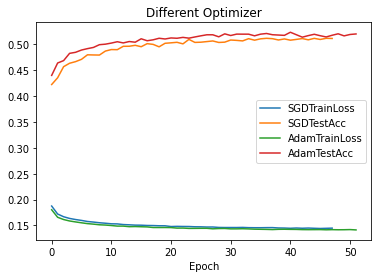

In [60]:
# Optimizer
candidate = ["SGD", "Adam"]
plt.title("Different Optimizer")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [62]:
# LR Test
trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainX = trainX_raw
testX = testX_raw

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
models = [Mlp3(), Mlp3(), Mlp3()]
candidate = [1e-2, 1e-3, 1e-4]
eval_data = []
time_cost = []
best_data = []
best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.AdamOptimizer(models[i].get_parameters(), lr=candidate[i], weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.18616773818964621, Train acc: 0.32373798076923077, Test loss: 0.16497769219716651, Test acc: 0.4098557692307692
Epoch 2: Train loss 0.170032950144469, Train acc: 0.386318108974359, Test loss: 0.15517165781101983, Test acc: 0.4465144230769231
Epoch 3: Train loss 0.16487558616055753, Train acc: 0.4080128205128205, Test loss: 0.15108735917567737, Test acc: 0.45723157051282054
Epoch 4: Train loss 0.1620166236810492, Train acc: 0.417588141025641, Test loss: 0.14875734546279268, Test acc: 0.46724759615384615
Epoch 5: Train loss 0.16025960866496514, Train acc: 0.4272435897435897, Test loss: 0.14793724758730936, Test acc: 0.4740584935897436
Epoch 6: Train loss 0.15891723712918526, Train acc: 0.42842548076923076, Test loss: 0.14785164289610414, Test acc: 0.46814903846153844
Epoch 7: Train loss 0.15817002297875687, Train acc: 0.4311498397435897, Test loss: 0.1475683592593514, Test acc: 0.4703525641025641
Epoch 8: Train loss 0.15795057008087196, Train acc: 0.4348357371794872

1e-2 162.80900692939758 (0.15448125020395712, 0.44511217948717946, 0.14138320174910346, 0.5018028846153846) 39
1e-3 254.26940155029297 (0.13921265305956304, 0.502383814102564, 0.1334156357490235, 0.5266426282051282) 91
1e-4 492.1130871772766 (0.14745499438948467, 0.46881009615384617, 0.1371366216929129, 0.5140224358974359) 153


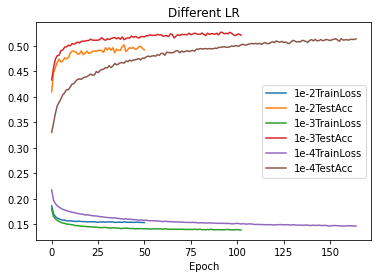

In [63]:
# LR
candidate = ["1e-2", "1e-3", "1e-4"]
plt.title("Different LR")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [64]:
# init

class MlpItest(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)
    
trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainX = trainX_raw
testX = testX_raw

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
candidate = [dl.nn.init.kai_ming_normal_init, 
             dl.nn.init.kai_ming_uniform_init,
             dl.nn.init.xavier_normal_init,
             dl.nn.init.xavier_uniform_init]
models = [MlpItest(i) for i in candidate]
eval_data = []
time_cost = []
best_data = []
best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.AdamOptimizer(models[i].get_parameters(), lr=1e-3, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.18264723344944206, Train acc: 0.34094551282051283, Test loss: 0.1602365488429037, Test acc: 0.4305889423076923
Epoch 2: Train loss 0.16721772498447646, Train acc: 0.39817708333333335, Test loss: 0.15457604319376214, Test acc: 0.44841746794871795
Epoch 3: Train loss 0.16261294118838138, Train acc: 0.41354166666666664, Test loss: 0.1506060821693064, Test acc: 0.46504407051282054
Epoch 4: Train loss 0.15949023534930307, Train acc: 0.42636217948717947, Test loss: 0.14763582134443679, Test acc: 0.47606169871794873
Epoch 5: Train loss 0.15766808471014743, Train acc: 0.4322716346153846, Test loss: 0.14578651800131212, Test acc: 0.48157051282051283
Epoch 6: Train loss 0.155382244370274, Train acc: 0.4385817307692308, Test loss: 0.14457662369861482, Test acc: 0.48066907051282054
Epoch 7: Train loss 0.1541801866195689, Train acc: 0.44364983974358974, Test loss: 0.14293828716922682, Test acc: 0.4918870192307692
Epoch 8: Train loss 0.15273518461873398, Train acc: 0.4498597756

KaimingNormal 114.6010479927063 (0.14226773044678215, 0.48655849358974357, 0.1346953612720886, 0.5208333333333334) 34
KaimingUniform 142.78805255889893 (0.14413095876374032, 0.4820713141025641, 0.13621125625925418, 0.5154246794871795) 34
XavierNormal 206.2884509563446 (0.14108300466879087, 0.4913461538461538, 0.1333102688365889, 0.5239383012820513) 61
XavierUniform 139.48362636566162 (0.14146939120577612, 0.49274839743589743, 0.13477646771850807, 0.5236378205128205) 46


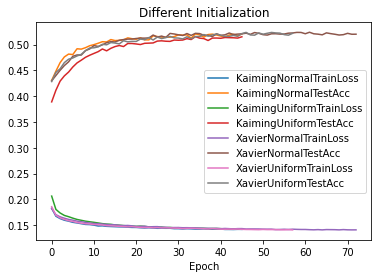

In [65]:
# initialization
candidate = ["KaimingNormal", "KaimingUniform", "XavierNormal", "XavierUniform"]
plt.title("Different Initialization")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [67]:
# BN

xn = dl.nn.init.xavier_normal_init
class MlpB(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

class MlpNB(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)
    
trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainX = trainX_raw
testX = testX_raw

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
candidate = []
models = [MlpB(xn),MlpNB(xn)]
eval_data = []
time_cost = []
best_data = []

best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.AdamOptimizer(models[i].get_parameters(), lr=1e-3, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3,
                                        tolerance_round=20)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.1826213867755028, Train acc: 0.3438301282051282, Test loss: 0.16618551174820295, Test acc: 0.41556490384615385
Epoch 2: Train loss 0.17223633078620268, Train acc: 0.3840945512820513, Test loss: 0.1603008044311358, Test acc: 0.43359375
Epoch 3: Train loss 0.16736584893716794, Train acc: 0.3998798076923077, Test loss: 0.15547833938089964, Test acc: 0.4476161858974359
Epoch 4: Train loss 0.16472007162702115, Train acc: 0.409775641025641, Test loss: 0.15258436725961502, Test acc: 0.45462740384615385
Epoch 5: Train loss 0.16224739520088438, Train acc: 0.4167467948717949, Test loss: 0.1500360109502872, Test acc: 0.46203926282051283
Epoch 6: Train loss 0.16023971581259097, Train acc: 0.4226161858974359, Test loss: 0.14852770588013614, Test acc: 0.46564503205128205
Epoch 7: Train loss 0.15867358995020384, Train acc: 0.42978766025641024, Test loss: 0.14671106828294664, Test acc: 0.4696514423076923
Epoch 8: Train loss 0.1575601850632061, Train acc: 0.43012820512820515, Test

WithBN 203.3823938369751 (0.14123312157457227, 0.49405048076923075, 0.132866989941816, 0.5241386217948718) 62
WithoutBN 252.76957392692566 (0.14083926696854712, 0.4940304487179487, 0.13437819588256994, 0.5248397435897436) 84


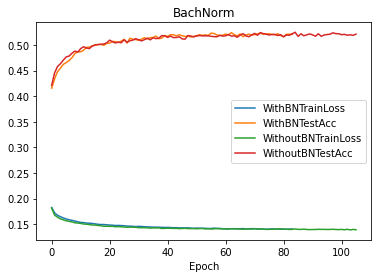

In [68]:
# BN
candidate = ["WithBN", "WithoutBN"]
plt.title("BachNorm")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [69]:
# DP

xn = dl.nn.init.xavier_normal_init
class MlpD(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        # self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        # self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        # out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        # out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

class MlpND(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        # self.bn1 = dl.Layers.BatchNormLayer(64)
        # self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        # self.bn2 = dl.Layers.BatchNormLayer(32)
        # self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        # out = self.bn1(out)
        # out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        # out = self.bn2(out)
        # out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)
    
trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainX = trainX_raw
testX = testX_raw

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
candidate = []
models = [MlpD(xn),MlpND(xn)]
eval_data = []
time_cost = []
best_data = []

best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.AdamOptimizer(models[i].get_parameters(), lr=1e-3, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3,
                                        tolerance_round=20)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.18218552675893676, Train acc: 0.3390625, Test loss: 0.1631630876440768, Test acc: 0.4169671474358974
Epoch 2: Train loss 0.16820419204583265, Train acc: 0.3959935897435897, Test loss: 0.15579699815331108, Test acc: 0.4469150641025641
Epoch 3: Train loss 0.1631722014537359, Train acc: 0.417588141025641, Test loss: 0.15100900226923003, Test acc: 0.4622395833333333
Epoch 4: Train loss 0.15957862151120067, Train acc: 0.4266826923076923, Test loss: 0.14869488105625978, Test acc: 0.47205528846153844
Epoch 5: Train loss 0.15801428714565222, Train acc: 0.43331330128205126, Test loss: 0.14694199432216654, Test acc: 0.47155448717948717
Epoch 6: Train loss 0.15624766080848856, Train acc: 0.4398036858974359, Test loss: 0.14553427708645758, Test acc: 0.48046875
Epoch 7: Train loss 0.1546915761576139, Train acc: 0.4483974358974359, Test loss: 0.1441999064492075, Test acc: 0.48517628205128205
Epoch 8: Train loss 0.15318947765598392, Train acc: 0.4505208333333333, Test loss: 0.14

WithDP 245.43081974983215 (0.13998772153056513, 0.4954727564102564, 0.13407760592985668, 0.5224358974358975) 81
WithoutDP 71.33395743370056 (0.11897286193420872, 0.5742788461538462, 0.13630863181840605, 0.5247395833333334) 13


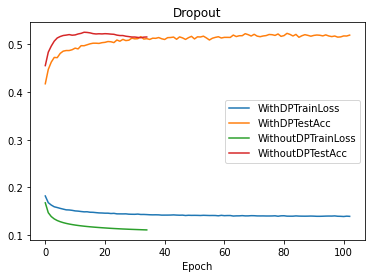

In [70]:
# DP
candidate = ["WithDP", "WithoutDP"]
plt.title("Dropout")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()

In [72]:
# BN without DP

xn = dl.nn.init.xavier_normal_init
class MlpB(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        # self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        # self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        # out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        # out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)

class MlpBD(dl.nn.Module):

    def __init__(self, init):
        super().__init__()
        self.fc1 = dl.Layers.DenseLayer(128, 64, initializer=init)
        self.bn1 = dl.Layers.BatchNormLayer(64)
        self.dp1 = dl.Layers.DropoutLayer(0.25)
        self.fc2 = dl.Layers.DenseLayer(64, 32, initializer=init)
        self.bn2 = dl.Layers.BatchNormLayer(32)
        self.dp2 = dl.Layers.DropoutLayer(0.25)
        self.fc3 = dl.Layers.DenseLayer(32, 10, initializer=init)
        self.out = dl.SoftMax()

    def forward(self, X):
        out = self.fc1(X)
        out = self.bn1(out)
        out = self.dp1(out)
        out = dl.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.dp2(out)
        out = dl.relu(out)
        out = self.fc3(out)
        return self.out(out)
    
trainy = dl.utils.preprocessing.one_hot_encode(trainy_raw)
testy = dl.utils.preprocessing.one_hot_encode(testy_raw)

trainX = trainX_raw
testX = testX_raw

trainset = dl.dataset.DataSet(trainX, trainy, batch_size=128, shuffle=True)
testset = dl.dataset.DataSet(testX, testy, batch_size=128, shuffle=True)

#####
candidate = []
models = [MlpB(xn),MlpBD(xn)]
eval_data = []
time_cost = []
best_data = []

best_round = []
######
for i in range(len(models)):
    loss_func = dl.metrics.CrossEntropyLoss()
    optimizer = dl.optimizer.AdamOptimizer(models[i].get_parameters(), lr=1e-3, weight_decay=0.02)
    scheduler = dl.optimizer.LRDecayScheduler(optimizer)
    param = [models[i], loss_func, scheduler, optimizer]
    session = dl.utils.EarlyStoppingPipe(models[i], 
                                         train, 
                                         1000, 
                                         params=param, 
                                         value_on_watch=3,
                                        tolerance_round=20)
    begin = time.time()
    session.run()
    end = time.time()
    ####
    time_cost.append(end-begin)
    eval_data.append(session.get_evaluation_data())
    best_data.append(session.get_evaluation_data()[session.best_round])
    best_round.append(session.best_round)
    ####

Epoch 1: Train loss 0.17053525264560968, Train acc: 0.39278846153846153, Test loss: 0.15922810630358844, Test acc: 0.43379407051282054
Epoch 2: Train loss 0.1574153984671025, Train acc: 0.44479166666666664, Test loss: 0.15436183237388132, Test acc: 0.452724358974359
Epoch 3: Train loss 0.15310184342983285, Train acc: 0.46127804487179486, Test loss: 0.15188826585860804, Test acc: 0.46334134615384615
Epoch 4: Train loss 0.15072460159734852, Train acc: 0.4700520833333333, Test loss: 0.1506636903543395, Test acc: 0.46864983974358976
Epoch 5: Train loss 0.1491907867857308, Train acc: 0.47652243589743587, Test loss: 0.14962372154561965, Test acc: 0.47115384615384615
Epoch 6: Train loss 0.14765234849899075, Train acc: 0.4812900641025641, Test loss: 0.14863051935106386, Test acc: 0.4762620192307692
Epoch 7: Train loss 0.1463320564192303, Train acc: 0.4844551282051282, Test loss: 0.14775447708234402, Test acc: 0.47836538461538464
Epoch 8: Train loss 0.1452037475430756, Train acc: 0.488341346153

BNOnly 562.3526277542114 (0.12249251201296601, 0.5650841346153846, 0.1395848613233856, 0.5084134615384616) 166
BNWithDP 272.37304425239563 (0.141064769040062, 0.4909855769230769, 0.13310982176808858, 0.5259415064102564) 78


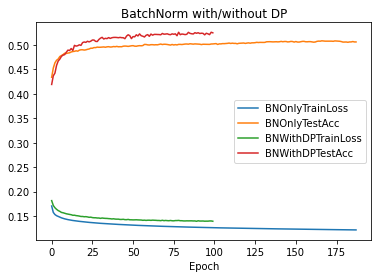

In [73]:
# BN without DP
candidate = ["BNOnly", "BNWithDP"]
plt.title("BatchNorm with/without DP")
plt.xlabel("Epoch")

train_loss = [[i[0] for i in j] for j in eval_data]
test_acc = [[i[3] for i in j] for j in eval_data]

for i in range(len(eval_data)):
    plt.plot([i for i in range(len(train_loss[i]))], train_loss[i], label=candidate[i]+"TrainLoss")
    plt.plot([i for i in range(len(train_loss[i]))], test_acc[i], label=candidate[i]+"TestAcc")
    print(candidate[i], time_cost[i], best_data[i], best_round[i])

plt.legend()
plt.show()